In [1]:
# General scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import pandas as pd
from string import ascii_lowercase
from scipy import special
from scipy import integrate
from scipy.special import roots_legendre, eval_legendre
from scipy.constants import mu_0, epsilon_0
# Machine Epssilon for float
import ipywidgets
import time
from PIL import Image
import os
eps = np.finfo(float).eps

In [2]:
# Specific Geophysics libraries
import empymod
# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import time_domain as tdem
from simpeg.electromagnetics import resistivity as dc
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from geoana.em.tdem import diffusion_distance
from geoana.em.tdem import peak_time
from pymatsolver import Pardiso

In [3]:
from masa_utils import PsuedoLog
from masa_utils import TEM_Signal_Process
from masa_utils import empymod_IPinv


Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019).
On-Time: 200msec
ramp time: 200usec
Transmitter Loop: 3.5m Square Loop
Receiver Loop: Coincident-type
Number of Turn: 5
3.5m rectangular loop has equivalent area for 2.0m circular. 

In [4]:
# load simpeg emip data
emip_saved = np.load("13_Validation_simpegEMIP.npy")
time_emip = emip_saved[0,:]
dpred_emip_b = emip_saved[1,:] 
dpred_emip_e = emip_saved[2,:] 
print(time_emip.shape)
print(time_emip.min())

print(dpred_emip_b.shape)
# load simpeg emip data
time_clc = np.load("13_time_clc.npy")
fields_saved = np.load("13_fields_emip.npy")
print(fields_saved.shape)
print(time_clc.shape)
print(time_clc.min())

(459,)
2e-06
(459,)
(31878, 459)
(459,)
2e-06


In [5]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [6]:
base_freq=1.25
on_time=200e-3
rmp_time=260e-6
rec_time=5e-3
smp_freq= 50e3 # 200e3 
# WISTEM_SP = TEM_Signal_Process (
#     base_freq=base_freq,
#     on_time=on_time,
#     rmp_time=rmp_time,
#     rec_time=rec_time,
#     smp_freq=smp_freq,
#)


In [7]:
csx, csz = tx_radius/4.,tx_radius/4.
ncx, ncz  = 100, 100 
pf, npadx, npadz = 1.3 , 26, 26
hx = [(csx, ncx), (csx, npadx, pf)]
hz = [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]
mesh = discretize.CylindricalMesh([hx,1,hz], '00C')    
print(f'number of mesh {mesh.nC}')

number of mesh 31752


In [8]:
# sea
sigma_sea =  3.0
res_sea = 1/sigma_sea
res_ref= 1/sigma_sea

# target
res0_target = 0.15
con0_target = 1/res0_target
eta_target = 0.3
con8_target = con0_target/(1-eta_target)
tau_target = 1.0e-3
c_target = 0.8
thick_target = 30.
tx_height = csx
print(tx_height)
print(f'con8 {con8_target:.2e}')
print(f'con0 {con0_target:.2e}')

# base
res_base = 1
con_seabed = 1/res_base

eta_sea , eta_base, eta_ref = 0.,0.,0.
tau_sea, tau_base, tau_ref = 1.0e-3, 1.0e-3, 1.0e-3
c_sea, c_base, c_ref = 0.6,0.6,0.6



0.4936658856042868
con8 9.52e+00
con0 6.67e+00


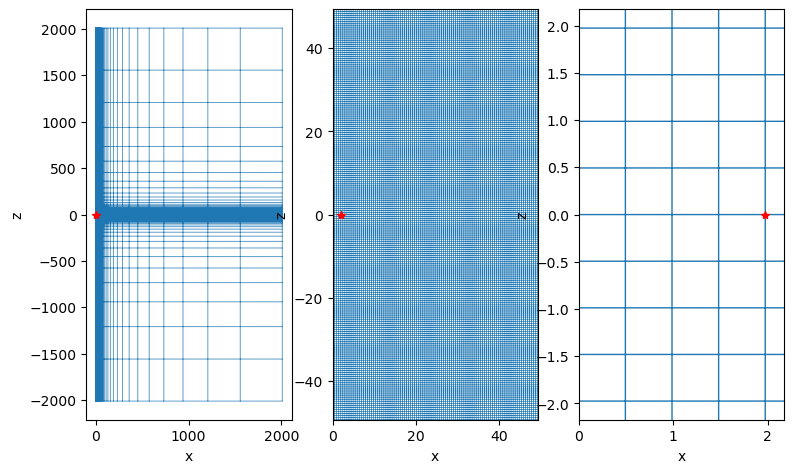

In [9]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.5)  
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.5)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0., ncx*csx)
ax[1].set_ylim(-ncz*csz , ncz*csz )
ax[2] =  mesh.plot_grid(ax=ax[2], show_it=False, linewidth=1.0)
ax[2].set_xlim(0.,tx_radius*1.1)
ax[2].set_ylim(-tx_radius*1.1,tx_radius*1.1)

for a in ax:
    a.set_aspect('equal')
    a.plot(tx_radius,0,'r*')
    a.grid(False)

# EMF directly from dBdt and E fields

In [10]:
ind_loop_dbdt = (
    (mesh.faces[:, 0] <= tx_radius +eps) 
    & (mesh.faces[:, 2] >  -( 0.1 * csz +eps)) 
    & (mesh.faces[:, 2] <  ( 0.1 * csz +eps))  
    )
print(ind_loop_dbdt.sum())   
print(mesh.faces[ind_loop_dbdt])
print(mesh.faces[ind_loop_dbdt].shape)
face_areas = mesh.face_areas[ind_loop_dbdt]
print(face_areas)
print(face_areas.sum())
dBdt = np.r_[mesh.edge_curl * fields_saved[:,:]][ind_loop_dbdt] 
print(dBdt.shape)
print(face_areas.shape)
#face_areas = mesh.face_areas[:, np.newaxis]
#dBdt = mesh.face_areas[ind_loop_dbdt] * dBdt[ind_loop_dbdt]   
dBdt_area =   dBdt.T @ face_areas
dBdt_area = n_turns*dBdt_area.squeeze()
print(dBdt_area.shape)


4
[[ 2.46832943e-01  0.00000000e+00 -1.70530257e-13]
 [ 7.40498828e-01  0.00000000e+00 -1.70530257e-13]
 [ 1.23416471e+00  0.00000000e+00 -1.70530257e-13]
 [ 1.72783060e+00  0.00000000e+00 -1.70530257e-13]]
(4, 3)
[0.765625 2.296875 3.828125 5.359375]
12.250000000000004
(4, 459)
(4,)
(459,)


In [11]:
ind_loop_e = (
       (mesh.edges[:, 0] > - 0.1*csx + tx_radius)
    &  (mesh.edges[:, 0] < + 0.1*csx + tx_radius)
    & (mesh.edges[:, 2] >  -( 0.1 * csz ))
    & (mesh.edges[:, 2] <  ( 0.1 * csz ))
)
print(ind_loop_e.sum())
print(mesh.edges[ind_loop_e])
edge_length = mesh.edge_lengths[ind_loop_e]
print(edge_length)
e_edge_length = np.r_[edge_length * fields_saved[ind_loop_e]][0,:] 
EMF_fields = n_turns * e_edge_length
print(e_edge_length.shape)

1
[[ 1.97466354e+00  0.00000000e+00 -1.70530257e-13]]
[12.40717696]
(459,)


(4, 459)


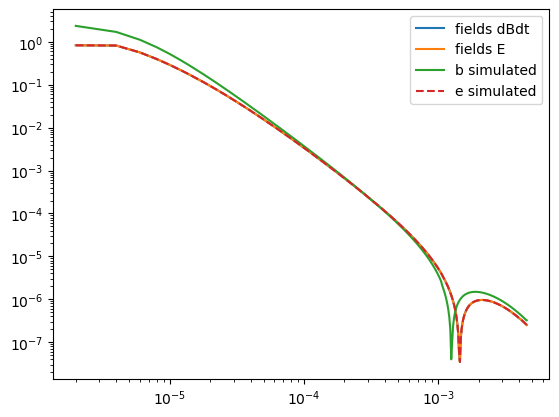

In [12]:

#dBdt = np.sum(dBdt,axis=0).T
print(dBdt.shape)
#plt.semilogx(time_emip,n_turns*dBdt.T, label="fields") 
plt.loglog(time_emip,np.abs(dBdt_area), label="fields dBdt ") 
plt.loglog(time_emip,np.abs(EMF_fields), label="fields E")
plt.loglog(time_emip,np.abs(dpred_emip_b), label="b simulated")
plt.loglog(time_emip,np.abs(dpred_emip_e),"--" ,label="e simulated")

plt.legend()

# Time step

In [13]:
#rx_times = [np.linspace(np.log10(e-5), np.log10(8e-3), 20)]
tstrt, tend = 1e-5, 4e-3
print(f'Peak time = {peak_time(z=tx_radius, sigma=sigma_sea):.2e} sec')

print(f'Earliest time = {tstrt:.2e} sec, \
Diffusion Depth: {diffusion_distance(sigma=sigma_sea, time=tstrt):.2e}')

print(f'''Latest time = {tend:.2e} sec, \
Diffusion Depth: {diffusion_distance(sigma=sigma_sea, time=tend):.2e}''')

# Compute transition time from Early to late time
print(f'Transition time between early and late time = {(mu_0 * (tx_radius**2) * sigma_sea) / 4:.5e}')

EarlyTime = mu_0 * sigma_sea * (tx_radius**2) / 4

Peak time = 2.45e-06 sec
Earliest time = 1.00e-05 sec, Diffusion Depth: 2.30e+00
Latest time = 4.00e-03 sec, Diffusion Depth: 4.61e+01
Transition time between early and late time = 3.67500e-06


# empymod implication

In [14]:
tstrt, tend = 1e-4, 4e-3
logstep = 1/15

WISTEM_SP_sim = TEM_Signal_Process(
    base_freq=base_freq,
    on_time=on_time, 
    rmp_time=rmp_time, 
    rec_time=tend, 
    smp_freq=smp_freq*4
)
PL_decay = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-5,
    linScalex=0.2
    )
PL_filt = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )

In [15]:
#time_empymod = time_emip
time_empymod = WISTEM_SP_sim.times_rec
nlayer = 2
depth = np.r_[0,thick_target] +tx_height* np.ones(nlayer)
#res_empymod = np.r_[1/con_sea, 1/con_target, 1/con_seabed]

In [16]:
recEbple =  [ [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # x1
             [ tx_side/2, -tx_side/2, -tx_side/2,  tx_side/2],  # x2
             [-tx_side/2,  tx_side/2,  tx_side/2, -tx_side/2],  # y1
             [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # y2
                tx_depth,  tx_depth]

In [17]:
# emoymod model to simulate WISTEM setting 
empymod_model_ebple = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
   # receiver is bipole about half of the side of transmitter loop
#    'freqtime' : time_clc[1:],
#    'res' : res, 
    'rec': recEbple,
    'depth': depth,
    'freqtime': time_empymod,
    'signal': -1, # Step off response
    'msrc' : False, # Electric source
    'mrec' : False, # Electric receiver
    'strength': 8*n_turns, # Multiply 8 cosidering the size of receiver bipole  
    'srcpts' : 3, # Three works for the momtent, maybe worth seeking larger number
    'verb': 0, # put 4 if you require information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [18]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_bdple = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    # receiver at the center of the transmitter loop
    'rec': [ 0,0,tx_depth,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
    'freqtime': time_empymod,
    'signal': 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': 8.*n_turns* tx_surface * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [19]:
def rec_area(nquad, tx_side):
    # Get roots and weights for the Legendre quadrature
    roots, weights = roots_legendre(nquad)
    
    # Scale roots by tx_side
    scaled_roots = roots * tx_side / 2.0

    # Create grid positions for x and y
    recx = np.tile(scaled_roots, nquad)  # Repeat scaled_roots nquad times for x
    recy = np.repeat(scaled_roots, nquad)  # Repeat each element of scaled_roots nquad times for y

    # Compute weights matrix (outer product of weights) and normalize
    w_array = weights.reshape(-1, 1)  # Column vector (nquad x 1)
    w_arrayT = weights.reshape(1, -1)  # Row vector (1 x nquad)
    matrix = np.dot(w_array, w_arrayT)  # Outer product to create weights grid
    recw = matrix.reshape(1, -1)  # Flatten the matrix to a 1D row vector
    recw /= recw.sum()  # Normalize weights to ensure they sum to 1
    return recx, recy, recw

    


In [20]:
nquad = 3
roots, weights = roots_legendre(nquad)
# Reshape weights into a column and row vector
w_array = weights.reshape(-1, 1)  # Column vector (3x1)
w_arrayT = weights.reshape(1, -1)  # Row vector (1x3)

# Compute the outer product (3x3 matrix)
matrix = np.dot(w_array, w_arrayT)
recw = matrix.reshape(1, -1)
recw /= recw.sum()
#print(recw.sum())
print("weights matrix Shape:", recw.shape)

scaled_roots = roots * tx_side / 2.0

# Create grid positions for x and y
recx = np.tile(scaled_roots, nquad)  # Repeat scaled_roots nquad times for x
recy = np.repeat(scaled_roots, nquad)  # Repeat each element of scaled_roots nquad times for y
print(recx)
print(recy)
print(recw)
recBdple =  recx, recy,tx_depth ,0,90

weights matrix Shape: (1, 9)
[-1.35554417  0.          1.35554417 -1.35554417  0.          1.35554417
 -1.35554417  0.          1.35554417]
[-1.35554417 -1.35554417 -1.35554417  0.          0.          0.
  1.35554417  1.35554417  1.35554417]
[[0.07716049 0.12345679 0.07716049 0.12345679 0.19753086 0.12345679
  0.07716049 0.12345679 0.07716049]]


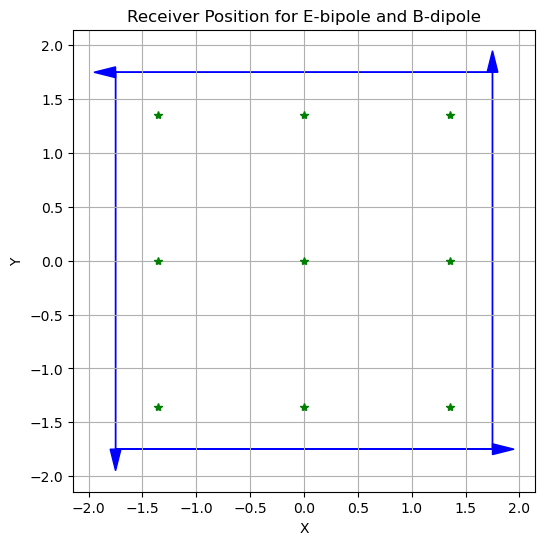

In [21]:
fig,ax= plt.subplots(1,1,figsize=(8,6))
# Extracting positions
x_start = recEbple[0]  # Start x-coordinates
x_end = recEbple[1]    # End x-coordinates
y_start = recEbple[2]  # Start y-coordinates
y_end = recEbple[3]    # End y-coordinates

# Calculate direction of arrows
dx = np.array(x_end) - np.array(x_start)
dy = np.array(y_end) - np.array(y_start)

for i in range(len(x_start)):
    ax.arrow(x_start[i], y_start[i], dx[i], dy[i], 
              head_width=0.1, head_length=0.2, fc='blue', ec='blue')
ax.plot(recBdple[0], recBdple[1], 'g*')

# Add labels and grid
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Receiver Position for E-bipole and B-dipole')
ax.grid()
ax.set_aspect('equal')
plt.show()


In [22]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_bdple_area = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    # receiver at the center of the transmitter loop
    'rec': recBdple, # [recx, recy, tx_depth ,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
    'freqtime': time_empymod,
    'signal': 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': 8.*n_turns* tx_surface * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [23]:
empymod_plot =  empymod_IPinv(model_base=empymod_model_bdple,
     nlayer=nlayer)
empymod_plot.fix_sea(
    res_sea=res_sea, chg_sea=eta_sea, 
    tau_sea=tau_sea, c_sea=c_sea
    )


(array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([-1.09861229,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -6.90775528,  0.        ,  0.        ,  0.6       ,
         0.        ,  0.        ]))

In [24]:
def pelton_et_al(inp, p_dict):
    """ Pelton et al. (1978)."""

    # Compute complex resistivity from Pelton et al.
    iotc = np.outer(2j * np.pi * p_dict['freq'], inp['tau']) ** inp['c']
    rhoH = inp['rho_0'] * (1 - inp['m'] * (1 - 1 / (1 + iotc)))
    rhoV = rhoH * p_dict['aniso'] ** 2

    # Add electric permittivity contribution
    etaH = 1 / rhoH + 1j * p_dict['etaH'].imag
    etaV = 1 / rhoV + 1j * p_dict['etaV'].imag
    return etaH, etaV

In [25]:
res = np.r_[res_sea,res0_target,res_base]
chg = np.r_[eta_sea,eta_target,eta_base]
tau = np.r_[tau_sea,tau_target,tau_base]
expc = np.r_[c_sea,c_target,c_base]
ip_model = {'res': res, 'rho_0': res, 'm': chg,
           'tau': tau, 'c': expc, 'func_eta': pelton_et_al}

In [27]:
empymod_bdple = empymod.bipole(res=ip_model,**empymod_model_bdple)
## Sum the four sides of the transmitter loop

#empymod_bdple = np.sum(empymod_bdple_four, axis=1)
dpred_empymod_bdple =  empymod_bdple #*mu_0 * tx_surface # *tx_circumeference

# Multiply by the number of turns
empymod_ebple = empymod.bipole(res=ip_model,**empymod_model_ebple)

dpred_empymod_ebple =  np.sum(empymod_ebple,axis=1)

empymod_bdple_area = empymod.bipole(res=ip_model,**empymod_model_bdple_area)
dpred_empymod_bdple_area = (recw @ empymod_bdple_area.T).squeeze()

print(f'dpred_ebple.shape : {dpred_empymod_ebple.shape}')
print(f'dpred_bdple.shape : {dpred_empymod_bdple.shape}')
print(f'dpred_bdple_area.shape : {dpred_empymod_bdple_area.shape}')



dpred_ebple.shape : (800,)
dpred_bdple.shape : (800,)
dpred_bdple_area.shape : (800,)


# plot model

In [26]:

mvec_r = np.log(np.r_[res0_target, res_base])
mvec_m = np.r_[eta_target,eta_base]

#mvec_m = np.r_[0.05,0]
mvec_t = np.log(np.r_[tau_target,tau_base ])
mvec_c = np.r_[c_target,c_base]
mvec = np.hstack([mvec_r, mvec_m, mvec_t, mvec_c])


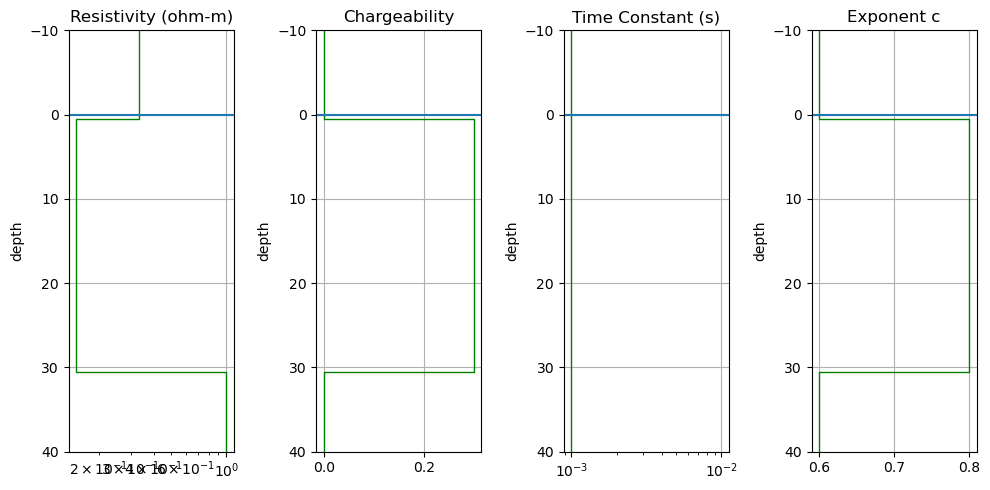

In [28]:
fig, ax = plt.subplots(1,4, figsize=(10,5))

ax = empymod_plot.plot_IP_par(mvec=mvec,ax=ax,color='g')
for i in range(4):  # Iterate over rows
    ax[i].set_ylim([40, -10])
    ax[i].axhline(tx_depth, label="Src+Rec")
    ax[i].set_ylabel('depth')
#    ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax[i].grid()
    if i== 0 or i ==2:
        ax[i].set_xscale("log")
    else:
        ax[i].set_xscale("linear")
plt.tight_layout()
plt.show()


# Load simpegemip data and compare

In [29]:
tstrt_plot, tend_plot = 1e-4, 4e-3

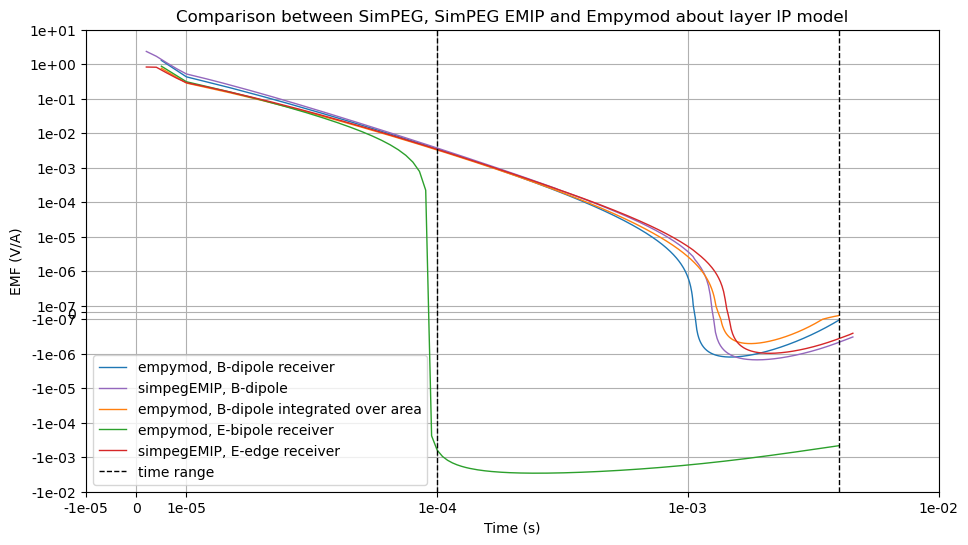

In [30]:
fig, ax = plt.subplots(1,1, figsize=(11,6))
#plt.loglog(time_emip, data_emip, '--k')
ax =PL_decay.plpl_plot(time_empymod , dpred_empymod_bdple, ax=ax,
         color='C0',label='empymod, B-dipole receiver') 
ax=PL_decay.plpl_plot(time_emip, dpred_emip_b, ax=ax,
         color="C4", label="simpegEMIP, B-dipole") 
ax=PL_decay.plpl_plot(time_empymod , dpred_empymod_bdple_area,ax=ax,
        color='C1',linestyle="-",label='empymod, B-dipole integrated over area') 
ax= PL_decay.plpl_plot(time_empymod , dpred_empymod_ebple, ax=ax,
        color= 'C2' , label='empymod, E-bipole receiver') 
ax=PL_decay.plpl_plot(time_emip, dpred_emip_e, ax=ax,
 color="C3", label="simpegEMIP, E-edge receiver") 
PL_decay.pl_axes(ax=ax)
PL_decay.pl_axes_x(ax=ax)

ax=PL_decay.pl_axvline(ax,tstrt, color='k', linestyle='--', label='time range')
ax=PL_decay.pl_axvline(ax,tend, color='k', linestyle='--')  # No need to repeat the label
plt.legend()
plt.ylabel('EMF (V/A)')
plt.xlabel('Time (s)')
plt.grid(True, which='both')
ax.set_title("Comparison between SimPEG, SimPEG EMIP and Empymod about layer IP model")
plt.show()